# Main imputation file 

- This file will create a dataset *either* by subsetting for the COVID portion, 
    - or simply returning a stitched version of the dataframe offsetting the points as if covid didn't happen. 



`TODO`
- `Review purpose of small_test` What is up with small_test? I repurposed code from noteboooks/bag_rev_forecast but its use feels redundant. 

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive
from statsforecast.models import AutoARIMA, AutoETS, AutoTheta
from utilsforecast.losses import mae, mape, rmse  

In [36]:
df = pd.read_csv(r"/home/rayan/Southwest_stuff/BaggageRevenueModel/combined_bag_revenue.csv")
df.head()

,Airline,2015-Q1,2015-Q2,2015-Q3,2015-Q4,2016-Q1,2016-Q2,2016-Q3,2016-Q4,2017-Q1,...,2022-Q3,2022-Q4,2023-Q1,2023-Q2,2023-Q3,2023-Q4,2024-Q1,2024-Q2,2024-Q3,2024-Q4
0,Alaska,23686.0,30215.0,34127.0,24787.0,30484.0,35022.0,39297.0,30811.0,30602.0,...,92981.0,80917.0,74482.0,97943.0,101337.0,84549.0,83934.0,106033.0,118372.0,98236.0
1,Allegiant,40444.0,42463.0,39934.0,38523.0,43759.0,45934.0,45168.0,42468.0,46556.0,...,83634.0,80586.0,88685.0,96696.0,86787.0,85386.0,90754.0,101292.0,90031.0,89385.0
2,American,151758.0,165660.0,292089.0,267293.0,262464.0,288836.0,288124.0,278048.0,272805.0,...,351356.0,348944.0,325296.0,352279.0,342047.0,337299.0,334743.0,394435.0,389782.0,382369.0
3,Delta,198119.0,226294.0,236890.0,213799.0,197690.0,232461.0,228971.0,213297.0,203507.0,...,252159.0,234831.0,226255.0,253222.0,259462.0,246286.0,239012.0,289749.0,259227.0,272113.0
4,Frontier,42011.0,49565.0,56582.0,71886.0,70755.0,71578.0,84962.0,79497.0,80224.0,...,201770.0,222968.0,221438.0,231463.0,211176.0,215842.0,203624.0,233695.0,212662.0,211643.0


In [37]:
# Reshape data for statsforecast

df_long = df.melt(id_vars=['Airline'], var_name='Quarter', value_name="Baggage Revenue")
df_long['Quarter'] = pd.PeriodIndex(df_long['Quarter'], freq='Q').to_timestamp(how="end")
df_long = df_long.rename(columns={"Airline": "unique_id", "Baggage Revenue": "y"})

# Final columns should be ['unique_id', 'ds', 'y']
df_long = df_long[['unique_id', 'Quarter', 'y']].rename(columns={"Quarter": "ds"})
df_long

,unique_id,ds,y
0,Alaska,2015-03-31 23:59:59.999999999,23686.0
1,Allegiant,2015-03-31 23:59:59.999999999,40444.0
2,American,2015-03-31 23:59:59.999999999,151758.0
3,Delta,2015-03-31 23:59:59.999999999,198119.0
4,Frontier,2015-03-31 23:59:59.999999999,42011.0
...,...,...,...
435,JetBlue,2024-12-31 23:59:59.999999999,143084.0
436,Southwest,2024-12-31 23:59:59.999999999,20956.0
437,Spirit,2024-12-31 23:59:59.999999999,123925.0
438,Sun Country,2024-12-31 23:59:59.999999999,25469.0


# Version 1: Create dataframe and ignore COVID period. 

Quarter information

| Q        | Date        |
| -------- | -------     |
| January  | 2021-03-31  |
| February | 2021-06-30  |
| March    | 2021-09-30  |
| 2021 Q4  | 2021-12-31  |


In [38]:
train_end = pd.Timestamp("2019-12-31")

covid_end = pd.Timestamp("2021-06-30")

train_pre_covid = df_long[df_long['ds'] <= train_end].copy()
post_covid_actual = df_long[df_long['ds'] > covid_end].copy()

# Calculate num of missing quarters
last_train_period = train_pre_covid['ds'].max().to_period('Q')
covid_end_period = covid_end.to_period('Q')
gap_quarters = (covid_end_period - last_train_period).n  

print(f"Num gap quarters offset {gap_quarters}")

# Shift post-COVID timestamps backward by that many quarters
post_covid_actual['ds'] = post_covid_actual['ds'] - pd.offsets.QuarterEnd(gap_quarters)

df_reindexed = (pd.concat([train_pre_covid, post_covid_actual]).sort_values(['unique_id', 'ds']).drop_duplicates(subset=['unique_id', 'ds'], keep='first').reset_index(drop=True))

df_reindexed.head(10)


Num gap quarters offset 7


,unique_id,ds,y
0,Alaska,2015-03-31 23:59:59.999999999,23686.0
1,Alaska,2015-06-30 23:59:59.999999999,30215.0
2,Alaska,2015-09-30 23:59:59.999999999,34127.0
3,Alaska,2015-12-31 23:59:59.999999999,24787.0
4,Alaska,2016-03-31 23:59:59.999999999,30484.0
5,Alaska,2016-06-30 23:59:59.999999999,35022.0
6,Alaska,2016-09-30 23:59:59.999999999,39297.0
7,Alaska,2016-12-31 23:59:59.999999999,30811.0
8,Alaska,2017-03-31 23:59:59.999999999,30602.0
9,Alaska,2017-06-30 23:59:59.999999999,38232.0


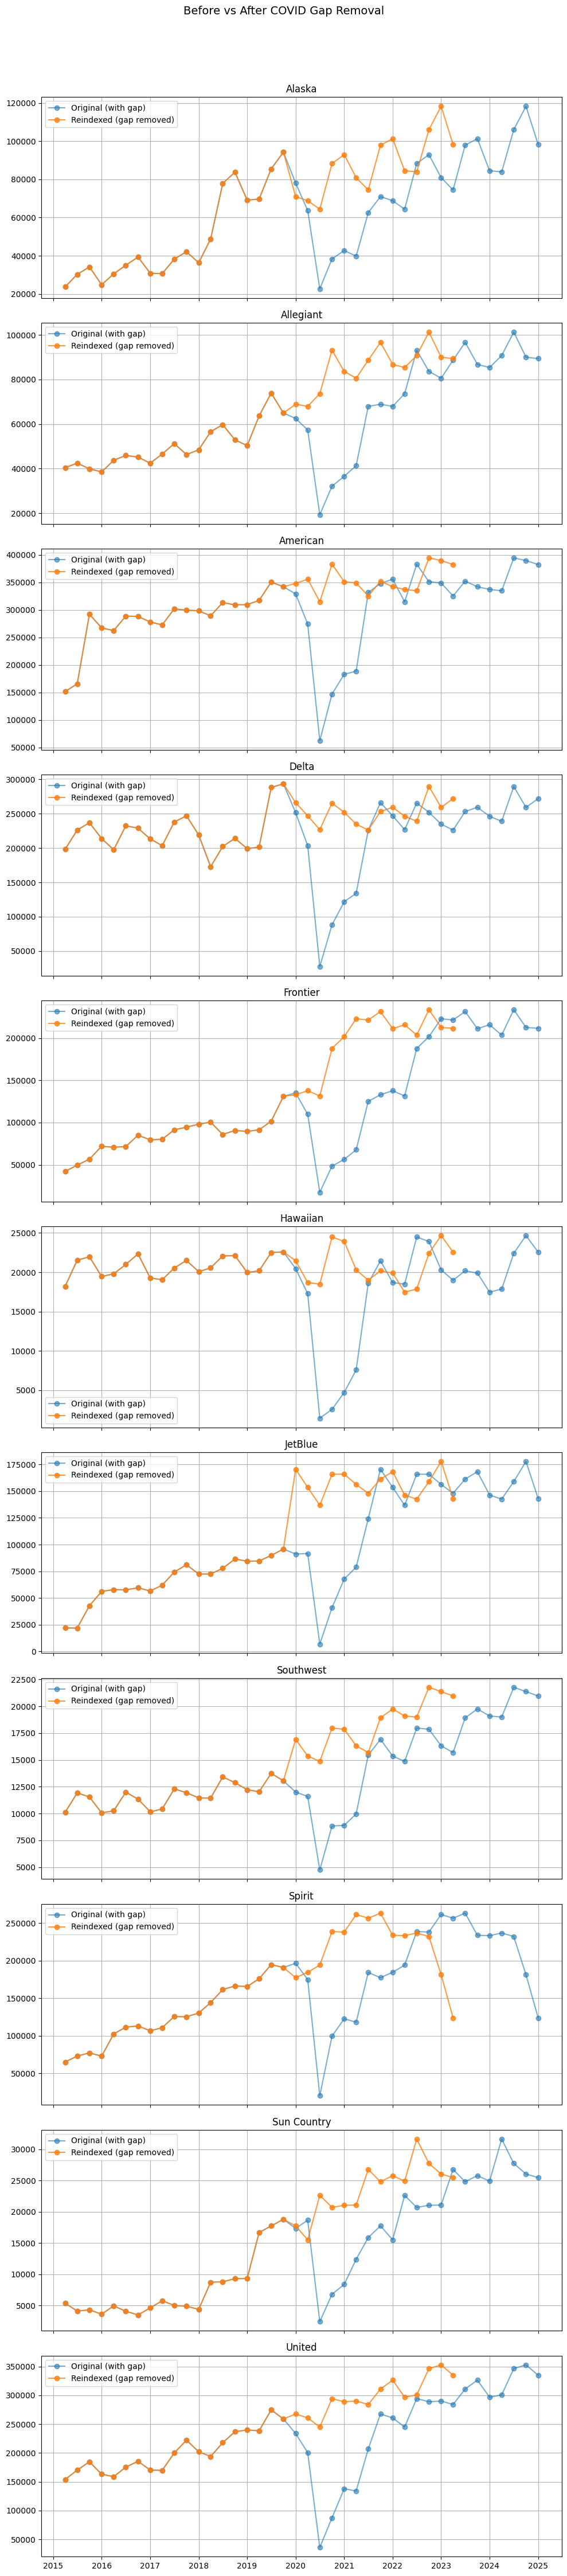

In [39]:
# NOTE UNCOMMENT BELOW FOR PLOT REGARDING ALL AIRLINES
airlines = df_long['unique_id'].unique()
# airlines= ['Southwest']


fig, axes = plt.subplots(len(airlines), 1, figsize=(10, 4*len(airlines)), sharex=True)

for i, airline in enumerate(airlines):
    ax = axes[i] if len(airlines) > 1 else axes

    df_orig = df_long[df_long['unique_id'] == airline]
    ax.plot(df_orig['ds'], df_orig['y'], marker='o', label='Original (with gap)', alpha=0.6)

    df_new = df_reindexed[df_reindexed['unique_id'] == airline]
    ax.plot(df_new['ds'], df_new['y'], marker='o', label='Reindexed (gap removed)', alpha=0.8)

    ax.set_title(f"{airline}")
    ax.legend()
    ax.grid(True)

plt.suptitle("Before vs After COVID Gap Removal", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# NOTE: REPLACE WITH ACTUAL PATH. 

df_reindexed.to_csv(r"/home/rayan/Southwest_stuff/BaggageRevenueModel/data/reindexed.csv")

# Version 2: Create dataframe and subset COVID period. 

`TODO`
- Figure out how to normalize inflation rate by CPI? 
- `Review purpose of small_test` What is up with small_test? I repurposed code from noteboooks/bag_rev_forecast but its use feels redundant. (CARRY OVER)

In [4]:
def build_fit_models(df, train, test, horizon, models=None, freq="QE"):
    ''' 
    df_train will contain columns unique_id, ds, y
    models will list all statsforecast models. Can pass better ones as list into function!
    freq(str) will be the frequency of the time series, QE for quarterly 
    '''

    unique_ids = df["unique_id"].unique().tolist()
    small_train = train[train["unique_id"].isin(unique_ids)]
    small_test = test[test["unique_id"].isin(unique_ids)]


    # Set up for downstream model changes
    # Change func if using different arima models. 
    if models is None: 
        models = [
            AutoARIMA(season_length=1, max_p=6, max_q=6, max_P=3, max_Q=3, alias="ARIMA"),
            AutoARIMA(season_length=4, max_p=6, max_q=6, max_P=3, max_Q=3, alias="SARIMA"),
            AutoETS(season_length=4, alias="ETS"),
            AutoTheta(season_length=4, alias="Theta"),
        ]
    sf = StatsForecast(models=models, freq='QE')
    sf.fit(df=small_train)

    sf = StatsForecast(models=models, freq='QE')
    sf.fit(df=small_train)
    arima_preds = sf.predict(h=horizon)

    arima_eval_df = pd.merge(test, arima_preds, 'left', ['ds', 'unique_id'])
    arima_eval = evaluate( df=arima_eval_df, metrics=[mae, mape, rmse] )
    arima_eval
    return sf, arima_eval

def forecast_period(sf, horizon, df_ref=None):
    '''
    df_ref will be an optional reference dataframe with unique_ids
    '''
    if df_ref is not None:
        unique_ids = df_ref["unique_id"].unique().tolist()
        return sf.predict(h=horizon)[sf.predict(h=horizon)["unique_id"].isin(unique_ids)]
    return sf.predict(h=horizon)

In [5]:
train_end = pd.Timestamp("2019-12-31")

covid_end = pd.Timestamp("2021-03-31")

train_pre_covid = df_long[df_long['ds'] <= train_end]
post_covid_actual = df_long[df_long['ds'] > covid_end]

print(train_pre_covid.head(-1))

last_train_period = train_pre_covid['ds'].max().to_period('Q')
covid_end_period = covid_end.to_period('Q')

horizon = covid_end_period - last_train_period 
horizon = horizon.n  
print(f"Forecast horizon (quarters): {horizon}")


# splitting the train pre covid portion into train and test for eval. 
test = (train_pre_covid.groupby('unique_id', group_keys=False).tail(horizon))
train = (train_pre_covid.drop(test.index).reset_index(drop=True))

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


       unique_id                            ds         y
0         Alaska 2015-03-31 23:59:59.999999999   23686.0
1      Allegiant 2015-03-31 23:59:59.999999999   40444.0
2       American 2015-03-31 23:59:59.999999999  151758.0
3          Delta 2015-03-31 23:59:59.999999999  198119.0
4       Frontier 2015-03-31 23:59:59.999999999   42011.0
..           ...                           ...       ...
203     Hawaiian 2019-09-30 23:59:59.999999999   22588.0
204      JetBlue 2019-09-30 23:59:59.999999999   95810.0
205    Southwest 2019-09-30 23:59:59.999999999   13046.0
206       Spirit 2019-09-30 23:59:59.999999999  191072.0
207  Sun Country 2019-09-30 23:59:59.999999999   18793.0

[208 rows x 3 columns]
Forecast horizon (quarters): 6
Train shape: (143, 3)
Test shape: (66, 3)


In [6]:
sf, arima_eval = build_fit_models(train_pre_covid, train, test, horizon)

covid_forecast = forecast_period(sf, horizon=horizon)

df_full = pd.concat([train_pre_covid, covid_forecast, post_covid_actual])
df_full.sort_values(by=['unique_id', 'ds'], inplace=True)

In [42]:
arima_eval

,unique_id,metric,ARIMA,SARIMA,ETS,Theta
0,Alaska,mae,31263.000000,31302.055556,37690.439290,33274.249190
1,Allegiant,mae,7652.833333,5692.111111,8781.404447,7437.510219
2,American,mae,34415.500000,34415.500000,33340.061630,13000.188379
3,Delta,mae,33313.500000,35671.833333,33324.323736,32579.823489
4,Frontier,mae,19616.791667,19616.791667,21253.352299,17470.067794
5,Hawaiian,mae,1361.417347,947.333333,1387.390079,1328.910017
6,JetBlue,mae,2936.750000,2936.750000,14031.337946,6595.840026
7,Southwest,mae,1740.141026,394.833333,516.723078,1181.929250
8,Spirit,mae,8547.041667,13168.639598,12700.517518,15501.910890
9,Sun Country,mae,8566.717949,7953.000000,7689.843474,7074.559303


In [43]:
df_full.head()

,unique_id,ds,y,ARIMA,SARIMA,ETS,Theta
0,Alaska,2015-03-31 23:59:59.999999999,23686.0,NaN,NaN,NaN,NaN
11,Alaska,2015-06-30 23:59:59.999999999,30215.0,NaN,NaN,NaN,NaN
22,Alaska,2015-09-30 23:59:59.999999999,34127.0,NaN,NaN,NaN,NaN
33,Alaska,2015-12-31 23:59:59.999999999,24787.0,NaN,NaN,NaN,NaN
44,Alaska,2016-03-31 23:59:59.999999999,30484.0,NaN,NaN,NaN,NaN


In [ ]:
# Extremely simple merge, just a one time checker. 

model_to_use = 'ARIMA' 

df_full['y'] = df_full['y'].fillna(df_full[model_to_use])

for airline_id in df_full['unique_id'].unique():
    df_plot = df_full[df_full['unique_id'] == airline_id].sort_values('ds')
    plt.figure(figsize=(12,4))
    sns.lineplot(x='ds', y='y', data=df_plot, marker='o')
    plt.title(f"Airline: {airline_id} — Y filled with {model_to_use}")
    plt.xlabel("Quarter")
    plt.ylabel("Baggage Revenue")
    plt.show()